# AirBnb in Brussels

## The dataset

The dataset is obtained from "[inside AirBnb](https://insideairbnb.com/get-the-data/)" and distributed under the [Creative Commons Attribution 4.0 International License](https://creativecommons.org/licenses/by/4.0/).

## Introduction

This markdown document is a summary of the results of the data analysis.
The code is reported in the following cells.

## Types of accommodations

To start, we check how many kinds of accommodations are available in the database. The accommodations can be:
* Entire home
* Private room
* Hotel room
* Shared room

<p style="text-align: center;">
  <img src="pie_accommodation.png" width="500" />
</p>

We plot the count of accommodation type per neighbourhood. Note that the second histogram is normalized to improve clarity. 
<p style="text-align: center;">
  <img src="neighborhoods_accommodation.png" width="500" /> 
  <img src="neighborhoods_accommodation_normalized.png" width="500" />
</p>

The distribution of accommodation types seems relatively uniform among neighbourhood.

**We observe that hotel rooms and shared rooms are rare in the dataset, consequently we exclude them from the following analysis.**

## Checking the reviews

The dataset contains six kinds of scores:
* Overall score
* Accuracy of the description
* Cleanliness
* Check-in experience
* Communication experience
* Location
* Value

We plot the correlation matrix of these scores.

<p style="text-align: center;">
![Correlation Scores](correlation_scores.png)
</p>

We preliminary observe that these scores are strongly correlated, with a coefficient often greather than 0.5. This is mostly due to the fact that many users tend to give a maximum rating to every score. We attempt an analysis of the scores, despite the presence of this problem, by making three observations.

First, the *location* score has a ralatively low correlation with all the other scores. We explain this by noticing that the quality of the location (intended as the quality of the neighborhood) is not directly under the control of the host. For example, a host can offer an excellent experience in terms of accuracy, cleanliness, check-in, and communication, but cannot do much to improve the quality of their neighborhood. **Interestingly, we observe that the location does not correlate much with the overall score, indicating that, on average, the users do not penalize the hosts by lowering their overall score when the location is not satisfactory.**

Second, the *cleanliness* correlates relatively poorly with *check-in* and *communication*. We explain this by noticing that, most commonly, the entity providing the cleaning service is different from the one providing the check-in and communication. Consequently, it is reasonable to observe that their scores do not correlate well.

Finally, we observe how the *overall* score correlates with the others. We see that *value* is the most correlated one, followed by *accuracy*, *cleanliness*, *check-in experience*, *communication* and, at last, *location*. **This can be interpreted as a list of what is more important to the user.** According to this list, for example, an inaccurate description can affect more the overall score than bad communication.

### Location score and price per neighborhood

Continuing the analysis started in the previous section, we visualize the location scores by neighborhood. To facilitate comparisons, we only considered accommodations for 2 persons. We also plot the prices per neighborhood.

<p style="text-align: center;">
<img src="neighborhoods_scores.png" width="500"/> 
<img src="neighborhoods_prices.png" width="500"/>
</p>

**This seems to be well correlated with the real estate value per neighborhood.** This finding is easy to explain: the real estate value is a good predictor of the attractiveness of a neighborhood, and consequently, it correlates well with the rating that the users give to a specific location, and with the price of the accommodation.

<p style="text-align: center;">
<img src="real_estate_prices.png" width="500"/>
</p>


### Scores and number of rooms

We observe that the some scores are inversely correlated with the numbers of listings of the same host. 

<p style="text-align: center;">
  <img src="correlation_scores_listings.png" width="400" />
</p>

In other words, **an host having multiple rooms for rent appears likely to have a lower score in communication, check-in experience, value, accuracy, and overall score.** Apparently, the number of rooms rented by the same host does not correlate significantly with cleaniless and location score. This can be explained by noticing that an host managing multiple properties does it in a less accurate way, thus reducing the quality of service. Cleaniless and location scores are, as imaginable, not well correlated because they do not directly depend on the host (the clean service is usually provided by someone different from the host, and the neighbourhood quality is out of the control of the host.)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pingouin as pg
import seaborn as sns

from collections import defaultdict

sns.set_theme(palette='flare', style='darkgrid')

filename = "listings.csv"
cols=["host_id","host_since","host_response_time","host_response_rate",
      "host_acceptance_rate","host_is_superhost","host_neighbourhood",
      "host_listings_count","host_total_listings_count","host_has_profile_pic",
      "host_identity_verified","neighbourhood_cleansed","latitude",
      "longitude","property_type","room_type",
      "accommodates",
      "beds","price",
      "number_of_reviews","review_scores_rating","review_scores_accuracy",
      "review_scores_cleanliness","review_scores_checkin","review_scores_communication",
      "review_scores_location","review_scores_value","instant_bookable",
      "calculated_host_listings_count","calculated_host_listings_count_entire_homes","calculated_host_listings_count_private_rooms",
      "calculated_host_listings_count_shared_rooms","reviews_per_month"]
data = pd.read_csv(filename, usecols=cols)

# Convert the prices from string to floats
data['price'] = data['price'].str.replace('\$', '', regex=True).str.replace(',', '').astype(float)

# Drop some entries that are clearly broken (normal appartments with price > 1500€ per night)
to_drop = [396, 1530, 1531]
data.drop(to_drop, inplace=True)

# Prepare a color palette, useful later
palette = []
for color in mcolors.TABLEAU_COLORS.values():
      palette.append(color)

C:\Users\aless\AppData\Roaming\Python\Python37\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [39]:
filename = "real_estate_prices.csv"
real_estate = pd.read_csv(filename, sep=';', index_col=0)

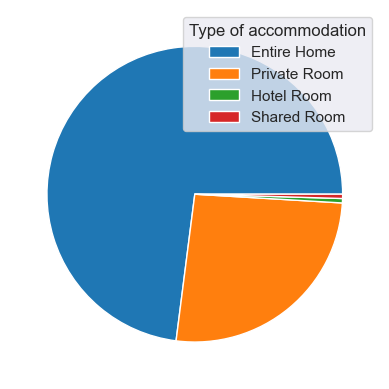

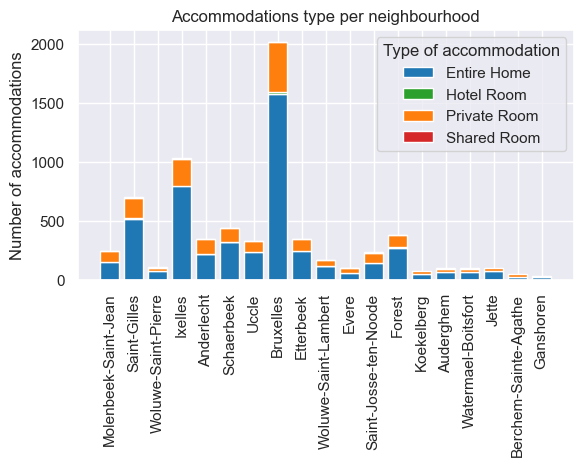

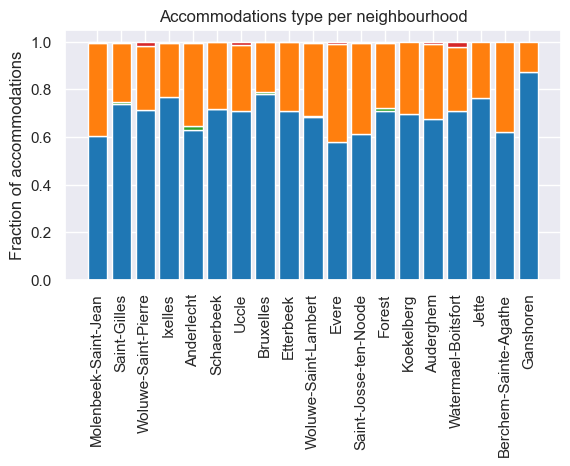

In [5]:
# Evaluate the kinds of accomodations in the dataset

ax = data['room_type'].value_counts().plot.pie(labels=None, colors=palette)
ax.legend(["Entire Home", "Private Room", "Hotel Room", "Shared Room"], title="Type of accommodation")
ax.set_ylabel("")
plt.savefig('pie_accommodation.png')
plt.show()

# Evaluate type of room per neighbourhood

room_type_per_neighbourhood = dict()
total_room_per_neighbourhood = dict()
for entry in data["neighbourhood_cleansed"].unique():
    room_type_per_neighbourhood[entry]=data[data['neighbourhood_cleansed']==entry]['room_type'].value_counts()
    total_room_per_neighbourhood[entry]=data[data['neighbourhood_cleansed']==entry]['room_type'].value_counts().sum()

i = 0
colors = dict()
for room_type in ['Entire home/apt',  'Private room', 'Hotel room', 'Shared room']: # Same order of the pie plot
    colors[room_type] = palette[i]
    i+=1

for neighbourhood in data["neighbourhood_cleansed"].unique():
    bottom = 0
    for room_type in data['room_type'].unique():
        if room_type in room_type_per_neighbourhood[neighbourhood]:
            plt.bar(neighbourhood, room_type_per_neighbourhood[neighbourhood][room_type], bottom=bottom, color=colors[room_type])
            bottom+=room_type_per_neighbourhood[neighbourhood][room_type]
        else:
            plt.bar(neighbourhood, 0, color=colors[room_type])
plt.legend(["Entire Home", "Hotel Room","Private Room",  "Shared Room"], title="Type of accommodation")
plt.xticks(range(len(data["neighbourhood_cleansed"].unique())), data["neighbourhood_cleansed"].unique(), rotation=90)
plt.ylabel("Number of accommodations")
plt.gcf().set_figheight(5)
plt.gcf().subplots_adjust(bottom=0.38)
plt.title("Accommodations type per neighbourhood")
plt.savefig('neighborhoods_accommodation.png')
plt.show()

# Do the same plot but now normalized

for neighbourhood in data["neighbourhood_cleansed"].unique():
    bottom = 0
    for room_type in data['room_type'].unique():
        if room_type in room_type_per_neighbourhood[neighbourhood]:
            plt.bar(neighbourhood, room_type_per_neighbourhood[neighbourhood][room_type]/total_room_per_neighbourhood[neighbourhood], bottom=bottom, color=colors[room_type])
            bottom+=room_type_per_neighbourhood[neighbourhood][room_type]/total_room_per_neighbourhood[neighbourhood]
        else:
            plt.bar(neighbourhood, 0, color=colors[room_type])
#plt.legend(["Entire Home", "Hotel Room","Private Room",  "Shared Room"], title="Type of accommodation")
plt.xticks(range(len(data["neighbourhood_cleansed"].unique())), data["neighbourhood_cleansed"].unique(), rotation=90)
plt.ylabel("Fraction of accommodations")
plt.gcf().set_figheight(5)
plt.gcf().subplots_adjust(bottom=0.38)
plt.title("Accommodations type per neighbourhood")
plt.savefig('neighborhoods_accommodation_normalized.png')
plt.show()

In [6]:
# Drop hotel rooms and shared rooms because they are not common in the dataset and could produce misleading results
data = data[data['room_type']!='Hotel room']
data = data[data['room_type']!='Shared room']


Text(0.5, 1.0, 'Correlation of scores')

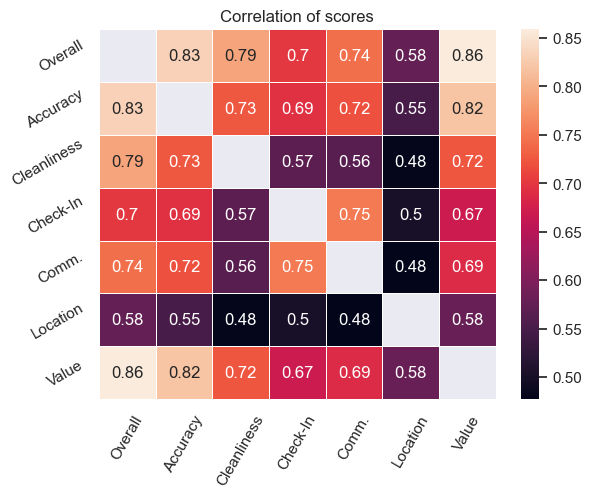

In [15]:
# Evaluate the correlation among different kinds of score

score_columns = ["review_scores_rating","review_scores_accuracy", "review_scores_cleanliness",
           "review_scores_checkin","review_scores_communication", "review_scores_location", 'review_scores_value']
labels  = ["Overall", "Accuracy", "Cleanliness","Check-In", "Comm.", "Location", "Value"]

corr = data[score_columns].corr()
sns.heatmap(data=corr, linewidths=.5, mask=np.identity(7, dtype=bool), annot=True, xticklabels=labels, yticklabels=labels)
plt.xticks(rotation=60)
plt.yticks(rotation=30)
plt.ylim(7,0)
plt.xlim(0,7)
plt.grid(visible=False)
plt.title("Correlation of scores")
#plt.savefig('correlation_scores.png', bbox_inches="tight")


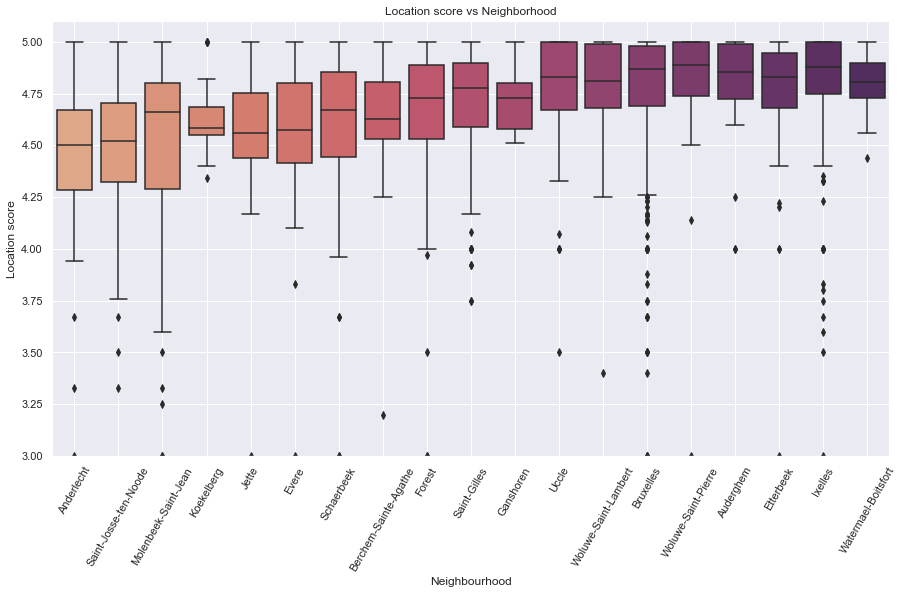

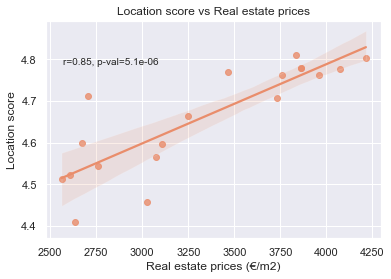

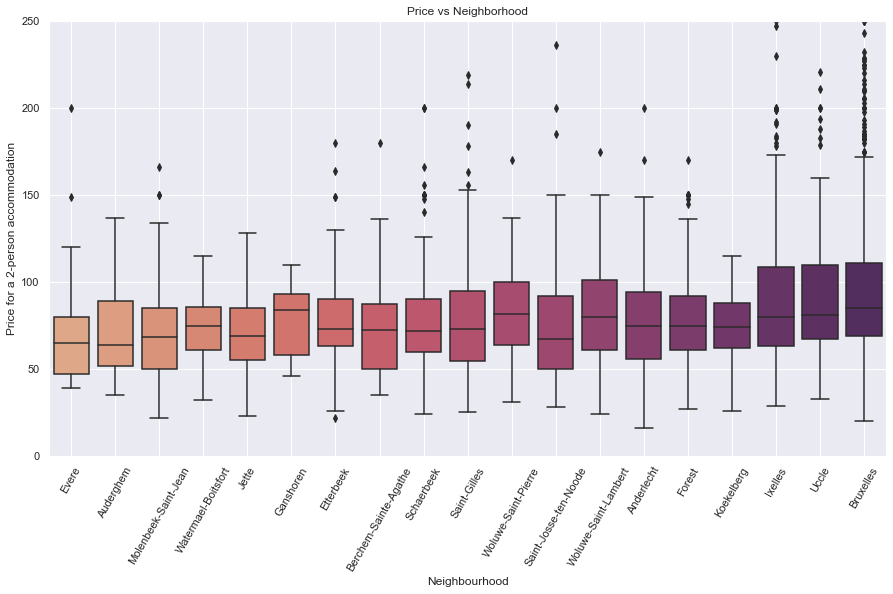

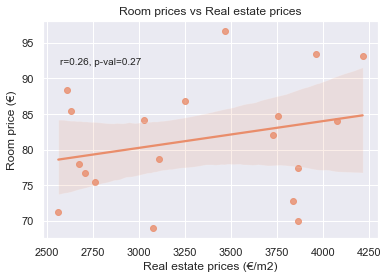

In [65]:
# Plot the location score and price for each neighborhood

neighborhoods = data["neighbourhood_cleansed"].unique()
data_2persons = data[data['accommodates']==2]

# First do the location scores
mean_total = data_2persons.groupby('neighbourhood_cleansed')['review_scores_location'].mean()
mean_per_neighborhood = [mean_total[entry] for entry in neighborhoods]

sorted_indexes = [i for i, _ in sorted(enumerate(mean_per_neighborhood), key=lambda x:x[1])]
neighborhoods  = [neighborhoods[idx] for idx in sorted_indexes]

plt.subplots(figsize=(15, 8))
sns.boxplot(data = data_2persons, x='neighbourhood_cleansed', y='review_scores_location', order=neighborhoods, palette='flare')
plt.ylim(3, 5.1)
plt.xticks(range(len(neighborhoods)), neighborhoods, rotation=60)
plt.grid(visible=True, axis='both')
plt.ylabel("Location score")
plt.xlabel("Neighbourhood")
plt.title("Location score vs Neighborhood")
plt.savefig('neighborhoods_scores.png', bbox_inches="tight")
plt.show()

real_estate_prices = []
location_scores    = []
for i in range(len(sorted_indexes)):
    real_estate_prices.append(real_estate.loc[[neighborhoods[i]]]['price_apartment'].to_list()[0])
    location_scores.append(mean_per_neighborhood[sorted_indexes[i]])
correlation_data = pg.corr(x=real_estate_prices, y=location_scores)

sns.regplot(x=real_estate_prices, y=location_scores)
plt.xlabel("Real estate prices (€/m2)")
plt.ylabel("Location score")
plt.title("Location score vs Real estate prices")
ax = plt.gca()
ax.text(.05, .8, 'r={:.2f}, p-val={:.2g}'.format(correlation_data['r'].to_list()[0], correlation_data['p-val'].to_list()[0]), transform=ax.transAxes)
plt.savefig('neighborhoods_scores_vs_prices.png', bbox_inches="tight")


# Now do the prices
mean_total = data_2persons.groupby('neighbourhood_cleansed')['price'].mean()
mean_per_neighborhood = [mean_total[entry] for entry in neighborhoods]

sorted_indexes = [i for i, _ in sorted(enumerate(mean_per_neighborhood), key=lambda x:x[1])]
neighborhoods  = [neighborhoods[idx] for idx in sorted_indexes]

plt.subplots(figsize=(15, 8))
sns.boxplot(data = data_2persons, x='neighbourhood_cleansed', y='price', order=neighborhoods, palette='flare')
plt.ylim(0, 250)
plt.xticks(range(len(neighborhoods)), neighborhoods, rotation=60)
plt.grid(visible=True, axis='both')
plt.ylabel("Price for a 2-person accommodation")
plt.xlabel("Neighbourhood")
plt.title("Price vs Neighborhood")
plt.savefig('neighborhoods_prices.png', bbox_inches="tight")
plt.show()

real_estate_prices = []
room_prices        = []
for i in range(len(sorted_indexes)):
    real_estate_prices.append(real_estate.loc[[neighborhoods[i]]]['price_apartment'].to_list()[0])
    room_prices.append(mean_per_neighborhood[sorted_indexes[i]])
correlation_data = pg.corr(x=real_estate_prices, y=room_prices)


sns.regplot(x=real_estate_prices, y=room_prices)
plt.xlabel("Real estate prices (€/m2)")
plt.ylabel("Room price (€)")
plt.title("Room prices vs Real estate prices")
ax = plt.gca()
ax.text(.05, .8, 'r={:.2f}, p-val={:.2g}'.format(correlation_data['r'].to_list()[0], correlation_data['p-val'].to_list()[0]), transform=ax.transAxes)
plt.savefig('room_prices_vs_prices.png', bbox_inches="tight")


In [63]:
correlation_data

,n,r,CI95%,p-val,BF10,power
pearson,19,0.845586,"[0.64, 0.94]",0.000005,4152.694,0.998996


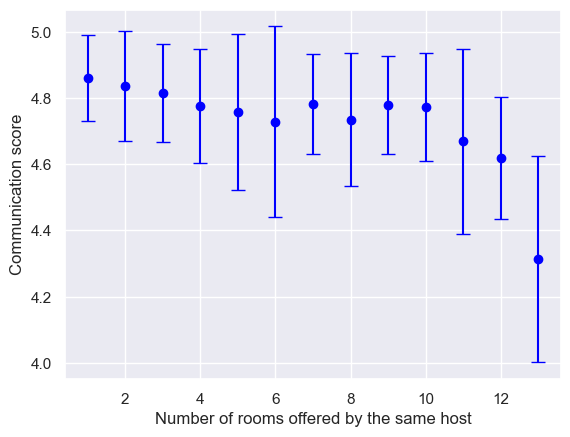

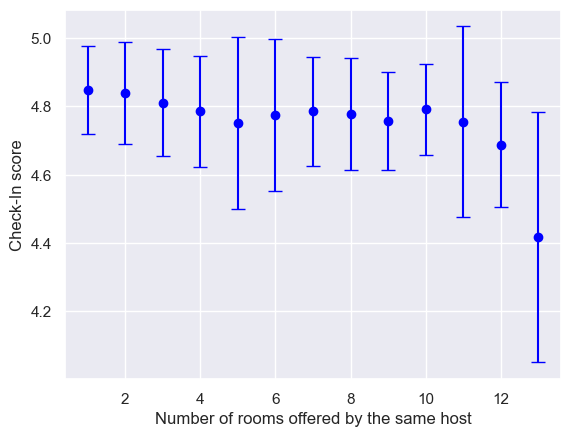

In [13]:
# Extract the correlation between listing count and scores

for count in range(1, 14):
    plt.errorbar(x=count, y=data[data['host_total_listings_count']==count]['review_scores_communication'].mean(),yerr= data[data['host_total_listings_count']==count]['review_scores_communication'].std()/2, fmt='o', color='blue', capsize=5)
plt.xlabel("Number of rooms offered by the same host")
plt.ylabel("Communication score")
plt.savefig('commscore_vs_listings.png')
plt.show()

plt.figure()
for count in range(1, 14):
    plt.errorbar(x=count, y=data[data['host_total_listings_count']==count]['review_scores_checkin'].mean(),yerr= data[data['host_total_listings_count']==count]['review_scores_checkin'].std()/2, fmt='o', color='blue', capsize=5)
plt.xlabel("Number of rooms offered by the same host")
plt.ylabel("Check-In score")
plt.savefig('checkinscore_vs_listings.png', bbox_inches="tight")
plt.show()

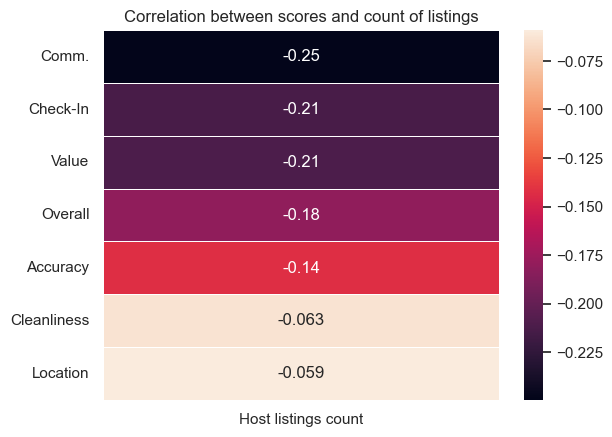

In [48]:
labels  = ["Comm.", "Check-In", "Value","Overall", "Accuracy", "Cleanliness", "Location"]
sns.heatmap(data=data_2persons[score_columns+['calculated_host_listings_count']].corr()['calculated_host_listings_count'].iloc[0:7].to_frame().sort_values('calculated_host_listings_count'), yticklabels=labels, xticklabels=['Host listings count'], linewidths=.5, annot=True)
plt.grid(visible=False)
plt.title("Correlation between scores and count of listings")
plt.savefig('correlation_scores_listings.png', bbox_inches="tight")